# Humpack whale migration routes - Interactive data visualization

## Species description
My closest encounter with a humpback whale took place during a month-long kayak trip in Alaska when I was 16. The water was the color of iron or mercury under the day's clouds, and everything was silent in the way only a fog-shrouded ocean wilderness can be. Suddenly the beast broke the surface only a few tens of feet away, with an explosion of steam that took my breath away and set my heart pounding. Our 10 foot kayak was a scrap of plastic to this thing. It surfaced several more times, a few minutes apart, just long enough for the suspense to build - curious, and investigating our small pod. Then it dove, and surfaced again far away across the bay.

Humpback whales, /Megaptera novaeangliae/, are known to migrate vast distances across the ocean. Perhaps by looking at the routes they choose, we can understand something more about their preferences, and their ocean habitat.

According to NOAA fisheries, humpback whales migrate seasonally up to 5,000 miles. They travel between cold, productive waters at high latitudes (in the northen hemisphere) or low latitudes (in the southern hemisphere) where they feed in the summer, and tropical waters where they mate and calve in the winter. At least four distinct populations exist in the North Pacific, each with their own unique feeding and calving areas and migration routes. There are at least two populations in the North Atlantic, and seven in the southern hemisphere (https://www.fisheries.noaa.gov/species/humpback-whale)

## Data description
Source for marine ecoregion boundaries: https://databasin.org/datasets/3b6b12e7bcca419990c9081c0af254a2/

Citation:
Spalding MD, Fox HE, Allen GR, Davidson N, Ferdaña ZA, Finlayson M, Halpern BS, Jorge MA, Lombana A, Lourie SA, Martin KD, McManus E, Molnar J, Recchia CA, Robertson J (2007) Marine Ecoregions of the World: a bioregionalization of coast and shelf areas. BioScience 57: 573-583.

GBIF occurrences

Whale occurrences data was gathered by individuals who contributed to a variety of datasets by recording observations of whales. These datasets were then compiled by the Global Biodiversity Information Facility (GBIF) into a searchable database. My search was limited to observations that included coordinates, and that took place in 2023. It returned occurrences observations from 37 datasets. The greatest number of observations was recorded by "Happy Whale", a resource intended to benefit conservation science.

Citation: GBIF.org (23 October 2024) GBIF Occurrence Download https://doi.org/10.15468/dl.mbcaqz

## Methods descriptions
The occurrences data are normalized by area, to account for sampling effort. This was done by counting the number of occurrences in each ecoregion, and dividing the number of occurences by the area to calculate the "density" of occurrences. 


In [1]:
# import packages
import os
import calendar
import cartopy.crs as ccrs
from getpass import getpass
from glob import glob
import geopandas as gpd
%pip install geoviews
import geoviews as gv
import hvplot.pandas
import pandas as pd
import panel as pn
import pathlib
import pygbif.occurrences as occ
import pygbif.species as species
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import time
import zipfile



Note: you may need to restart the kernel to use updated packages.


/opt/conda/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
%%bash
pip install pygbif

In [3]:
# Create data directory in the home folder
data_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    # Earth analytics data directory
    'earth-analytics',
    'data',
    # Project directory
    'whale-migration',
)
data_dir
os.makedirs(data_dir, exist_ok=True)

# Define the directory name for GBIF data
gbif_dir = os.path.join(data_dir, 'gbif')

Source for marine ecoregion boundaries: https://databasin.org/datasets/3b6b12e7bcca419990c9081c0af254a2/

Citation:
Spalding MD, Fox HE, Allen GR, Davidson N, Ferdaña ZA, Finlayson M, Halpern BS, Jorge MA, Lombana A, Lourie SA, Martin KD, McManus E, Molnar J, Recchia CA, Robertson J (2007) Marine Ecoregions of the World: a bioregionalization of coast and shelf areas. BioScience 57: 573-583.

In [4]:
# Define eco_path
eco_path = 'Marine_ecosystems.zip!MEOW/meow_ecos.shp'

# Open up the ecoregions boundaries
eco_gdf = (
    gpd.read_file(eco_path)
    [['ECO_CODE', 'ECOREGION', 'geometry']]
    .rename(columns={
        'ECO_CODE': 'ecoregion_ID',
        'ECOREGION': 'name',
    })
    .set_index('ecoregion_ID')
)

eco_gdf['area'] = eco_gdf.to_crs(9822).geometry.area/1000000

# Plot the ecoregions to check download
eco_gdf

,name,geometry,area
ecoregion_ID,,,
20192.0,Agulhas Bank,"POLYGON ((28.35993 -36.64435, 28.2835 -36.6769...",3.420362e+06
20053.0,Aleutian Islands,"MULTIPOLYGON (((-173.39419 55.59807, -168.5559...",5.386821e+06
20072.0,Amazonia,"POLYGON ((-41.13012 0.47319, -41.03905 0.4439,...",2.564858e+06
20194.0,Amsterdam-St Paul,"POLYGON ((77.52994 -34.5229, 77.92307 -34.5450...",2.746581e+06
20228.0,Amundsen/Bellingshausen Sea,"POLYGON ((-72.94222 -74.30962, -79.88636 -75.1...",5.643643e+08
...,...,...,...
25034.0,Ionian Sea,"POLYGON ((18.28997 40.28222, 18.46579 40.19296...",4.582846e+05
25031.0,Aegean Sea,"POLYGON ((26.80983 41.87778, 29.19196 41.03381...",6.136867e+05
25036.0,Alboran Sea,"POLYGON ((0.32179 32.44572, 0.23032 32.38912, ...",3.578930e+05


In [5]:
eco_gdf.head()

,name,geometry,area
ecoregion_ID,,,
20192.0,Agulhas Bank,"POLYGON ((28.35993 -36.64435, 28.2835 -36.6769...",3.420362e+06
20053.0,Aleutian Islands,"MULTIPOLYGON (((-173.39419 55.59807, -168.5559...",5.386821e+06
20072.0,Amazonia,"POLYGON ((-41.13012 0.47319, -41.03905 0.4439,...",2.564858e+06
20194.0,Amsterdam-St Paul,"POLYGON ((77.52994 -34.5229, 77.92307 -34.5450...",2.746581e+06
20228.0,Amundsen/Bellingshausen Sea,"POLYGON ((-72.94222 -74.30962, -79.88636 -75.1...",5.643643e+08


<Axes: >

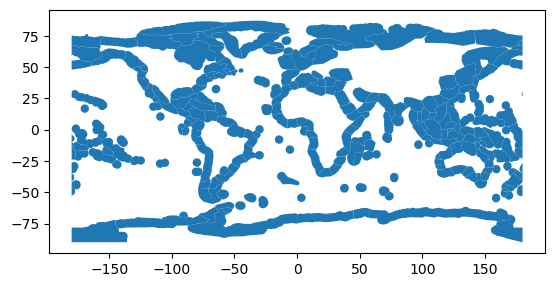

In [6]:
# Plot the ecoregions to check download
eco_gdf.plot()

In [7]:
reset_credentials = False
# GBIF needs a username, password, and email
credentials = dict(
    GBIF_USER=(input, 'GBIF username:'),
    GBIF_PWD=(getpass, 'GBIF password:'),
    GBIF_EMAIL=(input, 'GBIF email:'),
)
for env_variable, (prompt_func, prompt_text) in credentials.items():
    # Delete credential from environment if requested
    if reset_credentials and (env_variable in os.environ):
        os.environ.pop(env_variable)
    # Ask for credential and save to environment
    if not env_variable in os.environ:
        os.environ[env_variable] = prompt_func(prompt_text)

In [8]:
# Find out the species key used by GBIF to identify Megaptera novaeangliae

# Query species
species_info = species.name_lookup('Megaptera novaeangliae', rank='SPECIES')

# Get the first result
first_result = species_info['results'][0]

# Get the species key (nubKey)
species_key = first_result['nubKey']

# Check the result
first_result['species'], species_key

('Megaptera novaeangliae', 5220086)

In [9]:
# Only download once
gbif_pattern = os.path.join(gbif_dir, '*.csv')
if not glob(gbif_pattern):
    # Only submit one request
    if not 'GBIF_DOWNLOAD_KEY' in os.environ:
        # Submit query to GBIF
        gbif_query = occ.download([
            f"speciesKey = {5220086}",
            "hasCoordinate = True",
            "year = 2023",
        ])
        os.environ['GBIF_DOWNLOAD_KEY'] = gbif_query[0]

    # Wait for the download to build
    download_key = os.environ['GBIF_DOWNLOAD_KEY']
    wait = occ.download_meta(download_key)['status']
    while not wait=='SUCCEEDED':
        wait = occ.download_meta(download_key)['status']
        time.sleep(5)

    # Download GBIF data
    download_info = occ.download_get(
        os.environ['GBIF_DOWNLOAD_KEY'], 
        path=data_dir)

    # Unzip GBIF data
    with zipfile.ZipFile(download_info['path']) as download_zip:
        download_zip.extractall(path=gbif_dir)

# Find the extracted .csv file path (take the first result)
gbif_path = glob(gbif_pattern)[0]
gbif_path

'/home/jovyan/earth-analytics/data/whale-migration/gbif/0017082-241107131044228.csv'

In [10]:
!head -n 2 $gbif_path 

gbifID	datasetKey	occurrenceID	kingdom	phylum	class	order	family	genus	species	infraspecificEpithet	taxonRank	scientificName	verbatimScientificName	verbatimScientificNameAuthorship	countryCode	locality	stateProvince	occurrenceStatus	individualCount	publishingOrgKey	decimalLatitude	decimalLongitude	coordinateUncertaintyInMeters	coordinatePrecision	elevation	elevationAccuracy	depth	depthAccuracy	eventDate	day	month	year	taxonKey	speciesKey	basisOfRecord	institutionCode	collectionCode	catalogNumber	recordNumber	identifiedBy	dateIdentified	license	rightsHolder	recordedBy	typeStatus	establishmentMeans	lastInterpreted	mediaType	issue
4978476737	50c9509d-22c7-4a22-a47d-8c48425ef4a7	https://www.inaturalist.org/observations/250594013	Animalia	Chordata	Mammalia	Cetacea	Balaenopteridae	Megaptera	Megaptera novaeangliae		SPECIES	Megaptera novaeangliae (Borowski, 1781)	Megaptera novaeangliae		US		Massachusetts	PRESENT		28eb1a3f-1c15-4a95-931a-4af90ecb574d	42.030472	-70.307103	122.0						2023-09-20T1

In [11]:
# Load the GBIF data
gbif_df = pd.read_csv(
    gbif_path, 
    delimiter='\t',
    index_col='gbifID',
    usecols=['gbifID', 'decimalLatitude', 'decimalLongitude', 'month']
)
gbif_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38913 entries, 4978476737 to 4011495163
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   decimalLatitude   38913 non-null  float64
 1   decimalLongitude  38913 non-null  float64
 2   month             38886 non-null  float64
dtypes: float64(3)
memory usage: 1.2 MB


In [12]:
gbif_df

,decimalLatitude,decimalLongitude,month
gbifID,,,
4978476737,42.030472,-70.307103,9.0
4978465436,66.034955,-17.443391,8.0
4978406436,-42.501729,173.686505,1.0
4978351205,42.222313,-70.287645,8.0
4978336701,78.571389,8.718056,7.0
...,...,...,...
4011693247,20.627592,-105.568071,1.0
4011684281,20.739564,-105.362788,1.0
4011679282,20.657117,-105.326612,1.0


In [13]:
gbif_gdf = (
    gpd.GeoDataFrame(
        gbif_df, 
        geometry=gpd.points_from_xy(
            gbif_df.decimalLongitude, 
            gbif_df.decimalLatitude), 
        crs="EPSG:4326")
    # Select the desired columns
    [['month', 'geometry']]
)
gbif_gdf

,month,geometry
gbifID,,
4978476737,9.0,POINT (-70.3071 42.03047)
4978465436,8.0,POINT (-17.44339 66.03496)
4978406436,1.0,POINT (173.6865 -42.50173)
4978351205,8.0,POINT (-70.28764 42.22231)
4978336701,7.0,POINT (8.71806 78.57139)
...,...,...
4011693247,1.0,POINT (-105.56807 20.62759)
4011684281,1.0,POINT (-105.36279 20.73956)
4011679282,1.0,POINT (-105.32661 20.65712)


In [14]:
%store eco_gdf gbif_gdf

Stored 'eco_gdf' (GeoDataFrame)
Stored 'gbif_gdf' (GeoDataFrame)


In [15]:
gbif_ecoregion_gdf = (
    eco_gdf
    # Match the CRS of the GBIF data and the ecoregions
     .to_crs(gbif_gdf.crs)
    # Find ecoregion for each observation
    .sjoin(
        gbif_gdf,
        how='inner', 
        predicate='contains')
)
gbif_ecoregion_gdf

,name,geometry,area,gbifID,month
ecoregion_ID,,,,,
20192.0,Agulhas Bank,"POLYGON ((28.35993 -36.64435, 28.2835 -36.6769...",3.420362e+06,4407552892,8.0
20192.0,Agulhas Bank,"POLYGON ((28.35993 -36.64435, 28.2835 -36.6769...",3.420362e+06,4427045409,7.0
20192.0,Agulhas Bank,"POLYGON ((28.35993 -36.64435, 28.2835 -36.6769...",3.420362e+06,4427045407,7.0
20192.0,Agulhas Bank,"POLYGON ((28.35993 -36.64435, 28.2835 -36.6769...",3.420362e+06,4427045778,7.0
20192.0,Agulhas Bank,"POLYGON ((28.35993 -36.64435, 28.2835 -36.6769...",3.420362e+06,4427048471,10.0
...,...,...,...,...,...
25085.0,Gulf of Guinea South,"POLYGON ((13.11166 -1.08534, 13.15398 -1.15744...",9.361061e+05,4427047380,8.0
25085.0,Gulf of Guinea South,"POLYGON ((13.11166 -1.08534, 13.15398 -1.15744...",9.361061e+05,4427047381,8.0
25085.0,Gulf of Guinea South,"POLYGON ((13.11166 -1.08534, 13.15398 -1.15744...",9.361061e+05,4872007564,8.0


In [16]:
occurrence_df = (
    gbif_ecoregion_gdf
    #reset index
    .reset_index()
    # For each ecoregion, for each month...
    .groupby(['ecoregion_ID', 'month'])
    # ...count the number of occurrences
    .agg(
        occurrences=('gbifID', 'count'),
        area=('area', 'first'))
)

#Normalize by area
occurrence_df['density'] = (occurrence_df.occurrences 
              / occurrence_df.area
)

# Get rid of rare observations (possible misidentification?)
occurrence_df = occurrence_df[occurrence_df.occurrences>1]
occurrence_df


occurrences          area       density
ecoregion_ID month                                         
20002.0      5.0              2  5.380355e+05  3.717227e-06
             6.0              8  5.380355e+05  1.486891e-05
             7.0              9  5.380355e+05  1.672752e-05
             8.0              6  5.380355e+05  1.115168e-05
20003.0      7.0              7  1.599690e+06  4.375847e-06
...                         ...           ...           ...
25190.0      6.0              2  2.397421e+06  8.342299e-07
25199.0      1.0              3  7.383533e+06  4.063096e-07
             5.0              5  7.383533e+06  6.771826e-07
             6.0              9  7.383533e+06  1.218929e-06
             11.0             3  7.383533e+06  4.063096e-07

[425 rows x 3 columns]

In [17]:
# Take the mean by ecoregion
mean_occurrences_by_ecoregion = (
    occurrence_df
    .groupby('ecoregion_ID')
    .mean()
)
mean_occurrences_by_ecoregion

,occurrences,area,density
ecoregion_ID,,,
20002.0,6.250000,5.380355e+05,1.161633e-05
20003.0,4.666667,1.599690e+06,2.917231e-06
20004.0,24.000000,1.403924e+06,1.709494e-05
20005.0,21.666667,5.618537e+05,3.856283e-05
20018.0,25.500000,3.826869e+06,6.663411e-06
...,...,...,...
25147.0,2.000000,1.613630e+07,1.239441e-07
25152.0,651.571429,9.412568e+06,6.922356e-05
25184.0,7.000000,5.119241e+06,1.367390e-06


In [18]:
# Take the mean by month
mean_occurrences_by_month = (
    occurrence_df
    .groupby('month')
    .mean()
)
mean_occurrences_by_month

,occurrences,area,density
month,,,
1.0,111.517241,2.461128e+07,0.000061
2.0,94.657143,9.367862e+07,0.000045
3.0,92.100000,5.287040e+06,0.000050
4.0,60.913043,5.329806e+06,0.000081
5.0,48.827586,3.834827e+06,0.000081
6.0,69.763158,4.259685e+06,0.000091
7.0,130.108696,2.488975e+06,0.000164
8.0,124.826923,2.172032e+06,0.000155
9.0,101.404255,2.741738e+06,0.000132


In [19]:
# Normalize by space and time for sampling effort
occurrence_df['norm_occurrences'] = (
    occurrence_df[['density']]
    / mean_occurrences_by_ecoregion[['density']]
    / mean_occurrences_by_month[['density']]
)
occurrence_df

occurrences          area       density  norm_occurrences
ecoregion_ID month                                                           
20002.0      5.0              2  5.380355e+05  3.717227e-06       3952.523164
             6.0              8  5.380355e+05  1.486891e-05      14084.535377
             7.0              9  5.380355e+05  1.672752e-05       8786.571689
             8.0              6  5.380355e+05  1.115168e-05       6179.487777
20003.0      7.0              7  1.599690e+06  4.375847e-06       9152.678843
...                         ...           ...           ...               ...
25190.0      6.0              2  2.397421e+06  8.342299e-07      11003.543263
25199.0      1.0              3  7.383533e+06  4.063096e-07       9894.385097
             5.0              5  7.383533e+06  6.771826e-07      12351.634886
             6.0              9  7.383533e+06  1.218929e-06      19806.377874
             11.0             3  7.383533e+06  4.063096e-07      11223.694547

[425 rows x 4 columns]

In [20]:
%store occurrence_df

Stored 'occurrence_df' (DataFrame)


<Axes: xlabel='month', ylabel='norm_occurrences'>

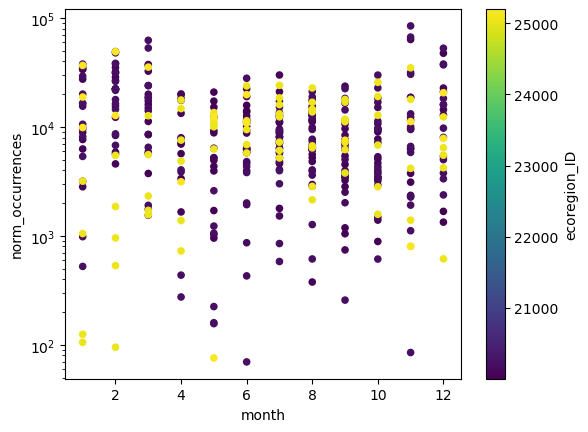

In [21]:
occurrence_df.reset_index().plot.scatter(
    x='month', y='norm_occurrences', c='ecoregion_ID', 
    logy=True
)

In [22]:
%store occurrence_df

Stored 'occurrence_df' (DataFrame)


In [23]:
# Simplify the geometry to speed up processing
eco_gdf.geometry = eco_gdf.simplify(.1, preserve_topology=False)

# Change the CRS to Mercator for mapping
eco_gdf = eco_gdf.to_crs(ccrs.Mercator())

# Check that the plot runs in a reasonable amount of time
eco_gdf.hvplot(geo=True, crs=ccrs.Mercator())

:Polygons   [Longitude,Latitude]

In [24]:
occurrence_df.head()

occurrences          area   density  norm_occurrences
ecoregion_ID month                                                       
20002.0      5.0              2  5.380355e+05  0.000004       3952.523164
             6.0              8  5.380355e+05  0.000015      14084.535377
             7.0              9  5.380355e+05  0.000017       8786.571689
             8.0              6  5.380355e+05  0.000011       6179.487777
20003.0      7.0              7  1.599690e+06  0.000004       9152.678843

In [25]:
(calendar.month_name[1:])

['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

In [26]:
# Join the occurrences with the plotting GeoDataFrame
occurrence_gdf = eco_gdf.join(occurrence_df[['norm_occurrences']])

# Get the plot bounds so they don't change with the slider
xmin, ymin, xmax, ymax = gbif_gdf.to_crs(ccrs.Mercator()).total_bounds

month_widget = pn.widgets.DiscreteSlider(
    options={
        calendar.month_name[month_num]: month_num
        for month_num in range(1, 12)
        }
)

# Plot occurrence by ecoregion and month
migration_plot = (
    occurrence_gdf
    .to_crs(ccrs.Mercator())
    .hvplot(
        c='norm_occurrences',
        groupby='month',
        # Use background tiles
        geo=True, crs=ccrs.Mercator(), tiles='CartoLight',
        title="Humpback Whale Migration",
        xlim=(xmin, xmax), ylim=(ymin, ymax),
        frame_height=600,
        widgets={'month': month_widget},
        widget_location='bottom'
    )
)
# Save the plot
migration_plot.save('whale-migration.html', embed=True)

# Show the plot
migration_plot

BokehModel(combine_events=True, render_bundle={'docs_json': {'3509b0db-1bff-41e3-8770-fde70e52ef03': {'version…

## Plot description, discussion, conclusion

The interactive plot above shows how many whales were observed in a particular ecoregion, at a particular time of year. Based on the sources I referenced above, it should be possible to see the patterns discussed earlier, with more observations at far Northern or Southern latitudes during summer months, and more observations in tropical waters during winter months. The pattern is difficult to dsicern, however it is possible to see in some areas. For example, the ecoregions off the Pacific Coast of North and Central America, along with Hawaii, do show a greater concentration of whales in Alaska during the summer months (particularly July), and in Mexico during the winter months (February).


In other places, the greater concentrations of whales do not appear to fit the pattern - for example there is a large concentration of observations recorded in Antarctica during February. This may be because whale migrations are more complicated than simply moving North or South based on the season. They may be based on more complex patterns such as the migration of food species, or even patterns of human activity. Another possibility is that the north-south migrations do occur, but observations are limited due to the extremely remote nature of many of the locations in question. A third possibility is that the whales are congregating in areas not marked by the Marine Ecoregions shapefile, which covered primarily coastal ecoregions and excluded some deeper ocean territory. Further study or additional data would be required in order to make these distinctions.